In [1]:
import json, os, pickle, random
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn

import qiskit
from qiskit import QuantumCircuit, execute
from qiskit.compiler import transpile
from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.quantum_info import SparsePauliOp, Operator
from qiskit.circuit.library import CXGate, RXGate, IGate, ZGate
from qiskit.providers.fake_provider import FakeMontreal, FakeLima

from blackwater.data.utils import (
    generate_random_pauli_sum_op,
    create_estimator_meas_data,
    circuit_to_graph_data_json,
    get_backend_properties_v1,
    encode_pauli_sum_op,
    create_meas_data_from_estimators
)

from mlp import MLP1, MLP2, MLP3, encode_data

from mbd_utils import cal_z_exp, generate_disorder, construct_mbl_circuit, calc_imbalance, modify_and_add_noise_to_model

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def fix_random_seed(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    print(f'random seed fixed to {seed}')

In [3]:
backend = FakeLima()
properties = get_backend_properties_v1(backend)

## Local
backend_ideal = QasmSimulator() # Noiseless
backend_noisy = AerSimulator.from_backend(FakeLima()) # Noisy

run_config_ideal = {'shots': 10000, 'backend': backend_ideal, 'name': 'ideal'}
run_config_noisy = {'shots': 10000, 'backend': backend_noisy, 'name': 'noisy'}

In [88]:
backend = FakeLima()
properties = get_backend_properties_v1(backend)

# Local, coherent noise
backend_ideal = QasmSimulator() # Noiseless
backend_noisy_coherent, noise_model = modify_and_add_noise_to_model()

run_config_ideal = {'shots': 10000, 'backend': backend_ideal, 'name': 'ideal'}
run_config_noisy_coherent = {'shots': 10000, 'backend': backend_noisy_coherent, 'name': 'noisy_coherent'}

In [4]:
def load_circuits(data_dir, f_ext='.json'):
    circuits = []
    ideal_exp_vals = []
    noisy_exp_vals = []
    data_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(f_ext)]
    for data_file in tqdm(data_files, leave=True):
        if f_ext == '.json':
            for entry in json.load(open(data_file, 'r')):
                circuits.append(QuantumCircuit.from_qasm_str(entry['circuit']))
                ideal_exp_vals.append(entry['ideal_exp_value'])
                noisy_exp_vals.append(entry['noisy_exp_values'])
        elif f_ext == '.pk':
            for entry in pickle.load(open(data_file, 'rb')):
                circuits.append(entry['circuit'])
                ideal_exp_vals.append(entry['ideal_exp_value'])
                noisy_exp_vals.append(entry['noisy_exp_values'])
    return circuits, ideal_exp_vals, noisy_exp_vals

In [5]:
train_circuits, train_ideal_exp_vals, train_noisy_exp_vals = load_circuits('./data/ising_init_0110/train/', '.pk')
print(len(train_circuits))

test_circuits, test_ideal_exp_vals, test_noisy_exp_vals = load_circuits('./data/ising_init_0110/val/', '.pk')
print(len(test_circuits))

  0%|          | 0/10 [00:00<?, ?it/s]

5000


  0%|          | 0/10 [00:00<?, ?it/s]

2000


In [6]:
# with open('./data/mbd_datasets2/theta_0.05pi/circuits.pk', 'rb') as infile:
#     loaded = pickle.load(infile)
#
# train_circuits = loaded['train_circuits']
# test_circuits = loaded['test_circuits']
# train_ideal_exp_vals = loaded['train_ideal_exp_vals']
# train_noisy_exp_vals = loaded['train_noisy_exp_vals']
# test_ideal_exp_vals = loaded['test_ideal_exp_vals']
# test_noisy_exp_vals = loaded['test_noisy_exp_vals']

In [7]:
train_noisy_exp_vals = [x[0] for x in train_noisy_exp_vals]
test_noisy_exp_vals = [x[0] for x in test_noisy_exp_vals]
X_train, y_train = encode_data(train_circuits, properties, train_ideal_exp_vals, train_noisy_exp_vals, num_qubits=4)
X_test, y_test = encode_data(test_circuits, properties, test_ideal_exp_vals, test_noisy_exp_vals, num_qubits=4)

In [8]:
BATCH_SIZE = 32
fix_random_seed(0)
train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE*1000, shuffle=False)

random seed fixed to 0


In [9]:
X_train = pd.DataFrame(X_train)#.iloc[:, -4:]
y_train = pd.DataFrame(y_train)
X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)

In [20]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
rfr_tree_list = []
for q in range(4):
    rfr = RandomForestRegressor(n_estimators=200)
    rfr.fit(X_train, y_train.iloc[:, q])
    rfr_tree_list.append(rfr)

In [136]:
# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# rfr = RandomForestRegressor(n_estimators=100)
# rfr.fit(X_train, y_train)

RandomForestRegressor()

In [21]:
with open('./model/ising_init_0110/rfr_list.pk', 'wb') as f:
    pickle.dump(rfr_tree_list, f)

random seed fixed to 0
RMSE_noisy_0: 0.1685884325247397
RMSE_mitigated_0: 0.014735869957341014
RMSE_noisy_1: 0.1424520076812326
RMSE_mitigated_1: 0.016629585242585215
RMSE_noisy_2: 0.09131246330496814
RMSE_mitigated_2: 0.016402079088955576
RMSE_noisy_3: 0.061593252706520184
RMSE_mitigated_3: 0.01481142691683181
RMSE_noisy: 0.1233352431458189
RMSE_mitigated: 0.015669201754501382


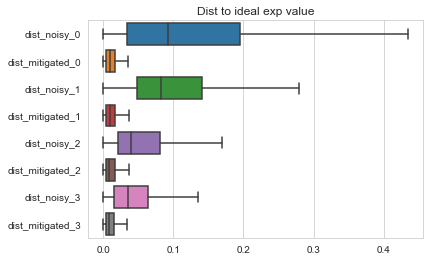

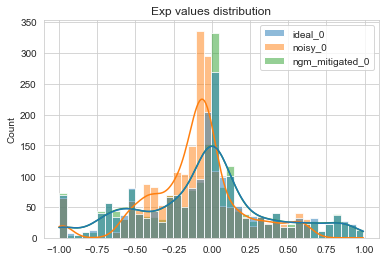

In [22]:
fix_random_seed(0)

distances = []

num_spins = 4
even_qubits = np.linspace(0, num_spins, int(num_spins/2), endpoint=False)
odd_qubits = np.linspace(1, num_spins+1, int(num_spins/2), endpoint=False)

for batch_X, batch_y in test_loader:
    out = []
    for q, model in enumerate(rfr_tree_list):
        out.append(model.predict(batch_X[:, :]))
    out = np.array(out).transpose()
    # out = rfr.predict(batch_X[:, -4:])

    for ideal, noisy, ngm_mitigated in zip(
        batch_y.tolist(),
        batch_X[:, -4:].tolist(),
        out.tolist()
    ):
        imbalance_ideal = calc_imbalance([ideal], even_qubits, odd_qubits)[0]
        imbalance_noisy = calc_imbalance([noisy], even_qubits, odd_qubits)[0]
        imbalance_mitigated = calc_imbalance([ngm_mitigated], even_qubits, odd_qubits)[0]
        for q in range(4):
            ideal_q = ideal[q]
            noisy_q = noisy[q]
            ngm_mitigated_q = ngm_mitigated[q]
            distances.append({
                f"ideal_{q}": ideal_q,
                f"noisy_{q}": noisy_q,
                f"ngm_mitigated_{q}": ngm_mitigated_q,
                f"dist_noisy_{q}": np.abs(ideal_q - noisy_q),
                f"dist_mitigated_{q}": np.abs(ideal_q - ngm_mitigated_q),
                f"dist_sq_noisy_{q}": np.square(ideal_q - noisy_q),
                f"dist_sq_mitigated_{q}": np.square(ideal_q - ngm_mitigated_q),
                "imb_ideal": imbalance_ideal,
                "imb_noisy": imbalance_noisy,
                "imb_ngm": imbalance_mitigated,
                "imb_diff": imbalance_ideal - imbalance_mitigated
            })

plt.style.use({'figure.facecolor':'white'})

df = pd.DataFrame(distances)

for q in range(4):
    print(f'RMSE_noisy_{q}:', np.sqrt(df[f"dist_sq_noisy_{q}"].mean()))
    print(f'RMSE_mitigated_{q}:', np.sqrt(df[f"dist_sq_mitigated_{q}"].mean()))

print(f'RMSE_noisy:', np.sqrt(np.mean([df[f"dist_sq_noisy_{q}"].mean() for q in range(4)])))
print(f'RMSE_mitigated:', np.sqrt(np.mean([df[f"dist_sq_mitigated_{q}"].mean() for q in range(4)])))

sns.boxplot(data=df[["dist_noisy_0", "dist_mitigated_0", "dist_noisy_1", "dist_mitigated_1", "dist_noisy_2", "dist_mitigated_2", "dist_noisy_3", "dist_mitigated_3"]], orient="h", showfliers = False)
plt.title("Dist to ideal exp value")
plt.show()

sns.histplot([df['ideal_0'], df['noisy_0'], df["ngm_mitigated_0"]], kde=True, bins=40)
plt.title("Exp values distribution")
plt.show()

# sns.histplot([df['imb_ideal'], df['imb_noisy'], df["imb_ngm"]], kde=True, bins=40)
# plt.title("Exp values distribution")
# plt.show()
#
# sns.histplot(data=df["imb_diff"], kde=True, bins=40)
# plt.title("Dist to ideal exp value")
# plt.show()